# Hyperparameter Search

In this notebook, we will find the best hyperparameters for our model. The optimal hyperparameters are specific to the dataset and task.

We will use two libraries created by HuggingFace: transformers and datasets.

We will also use the wandb library to track our training runs and the mean_squared error function from scikit-learn.

In [1]:
# Import classes for tokenization and model training
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)

# Import DatasetDict which will help us prepare our own dataset for use in training and evaulating machine learning models
from datasets import DatasetDict, Value

# Import function to be used as loss function
from sklearn.metrics import mean_squared_error

# Import library to track our training runs and change settings
import wandb

# Replace the variables below with your own: name, project name, and project directory
%env WANDB_ENTITY = langdon
%env WANDB_PROJECT = ellipse
%env WANDB_DIR = /home/jovyan/active-projects/ellipse-methods-showcase/bin

score_to_predict = 'overall_1'
model_name='microsoft/deberta-v3-large'

env: WANDB_ENTITY=langdon
env: WANDB_PROJECT=ellipse
env: WANDB_DIR=/home/jovyan/active-projects/ellipse-methods-showcase/bin


## Hyperparameter Optimization

Config is based on Appendix A.4:

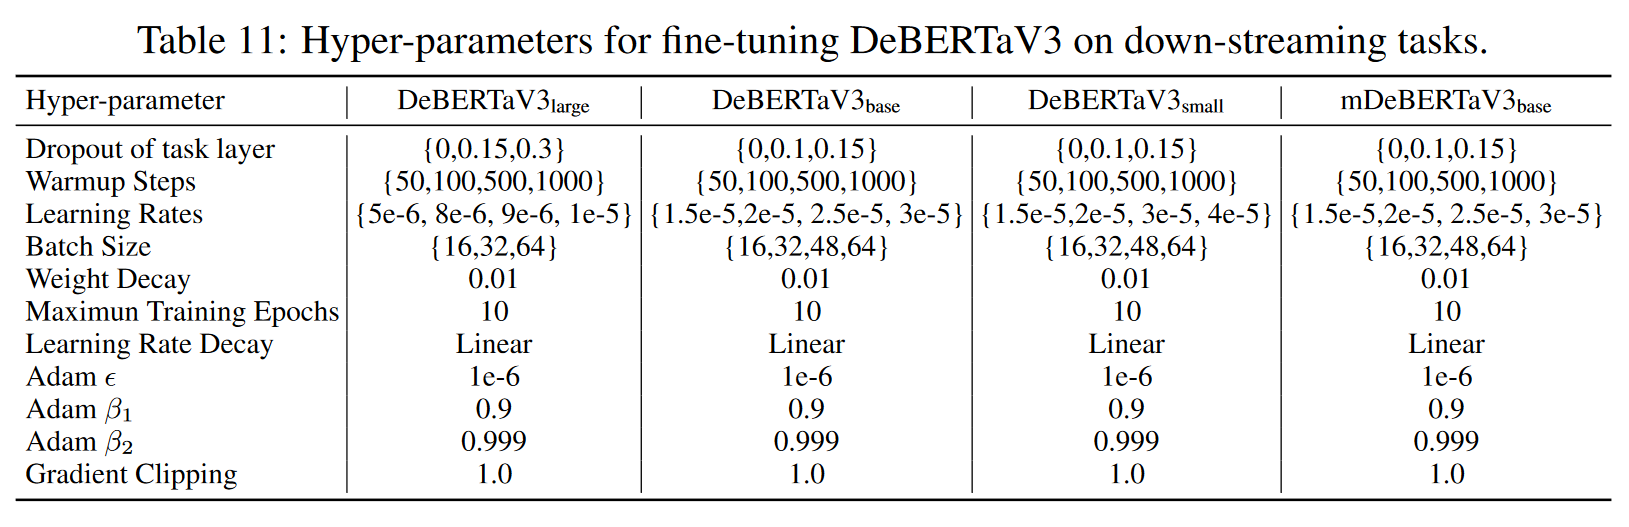

He, P., Gao, J., & Chen, W. (2023). DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing (arXiv:2111.09543). arXiv. https://doi.org/10.48550/arXiv.2111.09543

In [2]:
sweep_config = {
    'name': f'{score_to_predict}-{model_name}',
    'method': 'bayes',
    'run_cap': 42, # bayesian optimizer will run until stopped if this is not set
    'metric': {
        'name': f'eval/mse',
        'goal': 'minimize'}, # we want to "minimize" the mean squared error.
    'parameters': {
        'batch_size': {'value': 16}, # batch size of 32|64 is too large for our accelerator
        'learning_rate': {'values': [5e-6, 8e-6, 9e-6, 1e-5]},
        'num_train_epochs': {'values': [2, 3, 4, 5]}, # Up to 10 epochs are suggested, so we may need to extend this range if models are still improving at 4-5 epochs.
        'pooler_dropout': {'values': [0, 0.15, 0.30]},
        'weight_decay': {'value': 0.01},
        'adam_beta1': {'value': 0.900},
        'adam_beta2': {'value': 0.999},
        'adam_epsilon': {'value': 1e-6},
        'warmup_steps': {'values': [50, 100, 500, 1000]},
    },
}

## Create Model Initialization Function

The hyperparameter configuration refers to a dropout layer in the classifier head. Reading through [Microsoft's original implementation of DeBERTav3](https://github.com/microsoft/DeBERTa/blob/master/DeBERTa/apps/models/sequence_classification.py#L49) and the [HuggingFace implementation](https://github.com/huggingface/transformers/blob/v4.35.2/src/transformers/models/deberta_v2/configuration_deberta_v2.py#L42), it seems that we can configure this using the `pooler_dropout` parameter.



In [3]:
def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, pooler_dropout=config.pooler_dropout)

## Load Model and Tokenizer


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

In [5]:
# Create function that will take a text as an input, tokenize it, and return numeric representations for each individual token.
# We will be setting the truncation parameter to True this time.
def tokenize_inputs(example):
    return tokenizer(example['text'], max_length=512, truncation=True)

## Load DatasetDict

In [6]:
def get_datadict(score_to_predict):
    ''' Selects a target score that the model should predict and renames that score to 'label'.
    Removes other columns from the dataset. The other columns are not needed for training.
    '''
    
    # Load the DatasetDict object we created in the previous notebook. 
    # We will be removing the columns that we defined above, and renaming the target column (=score_to_predict) into 'label'
    dd = DatasetDict.load_from_disk('../data/raw_ellipse.hf')

    columns_to_remove = set(dd.column_names['train']).symmetric_difference(['id', 'text', score_to_predict])
    
    # Huggingface will look for a column that contains the string 'label' to calculate metrics.
    dd = dd.remove_columns(columns_to_remove).rename_column(score_to_predict, 'label')

    # The model expects a floating point value for regression-type training
    dd = dd.cast_column('label', Value("float32"))
    return dd

# Load dataset using the function
datadict = get_datadict(score_to_predict)

Casting the dataset:   0%|          | 0/6216 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1332 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1332 [00:00<?, ? examples/s]

### Tokenize the texts

In [7]:
datadict = datadict.map(tokenize_inputs, remove_columns=['id', 'text'])

Map:   0%|          | 0/6216 [00:00<?, ? examples/s]

Map:   0%|          | 0/1332 [00:00<?, ? examples/s]

Map:   0%|          | 0/1332 [00:00<?, ? examples/s]

## Evaluating Model Performance

In [8]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    mse = mean_squared_error(labels, preds)

    return {'mse': mse}

## Training Arguments

In [9]:
def train():
    with wandb.init():
        # set sweep configuration
        config = wandb.config

        # Customize the trainer
        training_args = TrainingArguments(
            output_dir = '../bin', 
            optim = 'adamw_torch', # Specify your optimizer
            logging_dir = f'../logs/{score_to_predict}', 
            load_best_model_at_end = False,
            metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
            evaluation_strategy='epoch', # Evaluate model performance at the end of each epoch
            save_strategy='no', # I prefer to perform a training run separately once the best parameters are discovered.
            greater_is_better = False,
            log_level = 'error',
            disable_tqdm = False,
            report_to='wandb',
            # The hyper parameters we are tuning (umber of epochs, learning rate, and batch size) are called in from the configuration dictionary
            num_train_epochs=config.num_train_epochs,
            warmup_steps=config.warmup_steps,
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=16,
        )

        model = model_init(config)

        # Initialize the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=datadict['train'],
            eval_dataset=datadict['dev'],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )


        # Start training loop
        trainer.train()

In [ ]:
# Start HP tuning. This will take a long time since we will be finetuning multiple models and comparing their performances.
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, train)

Create sweep with ID: lytxo83t
Sweep URL: https://wandb.ai/langdon/ellipse/sweeps/lytxo83t


wandb: Agent Starting Run: 8mfgcfug with config:
wandb: 	adam_beta1: 0.9
wandb: 	adam_beta2: 0.999
wandb: 	adam_epsilon: 1e-06
wandb: 	batch_size: 16
wandb: 	cls_drop_out: 0
wandb: 	epochs: 5
wandb: 	learning_rate: 5e-06
wandb: 	warmup_steps: 500
wandb: 	weight_decay: 0.01
wandb: Currently logged in as: langdon. Use `wandb login --relogin` to force relogin


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Mse
1,No log,0.748358,0.748358
2,3.073800,0.383175,0.383175
3,0.309200,0.329417,0.329417
4,0.272100,0.339837,0.339837
5,0.272100,0.434652,0.434652


eval/loss,█▂▁▁▃
eval/mse,█▂▁▁▃
eval/runtime,▃▁▄█▂
eval/samples_per_second,▆█▅▁▇
eval/steps_per_second,▅█▅▁▅
train/epoch,▁▂▃▄▅▆▆██
train/global_step,▁▁▃▄▅▆▆██
train/learning_rate,█▅▁
train/loss,█▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: 9w9kmwgq with config:
wandb: 	adam_beta1: 0.9
wandb: 	adam_beta2: 0.999
wandb: 	adam_epsilon: 1e-06
wandb: 	batch_size: 16
wandb: 	cls_drop_out: 0.15
wandb: 	epochs: 3
wandb: 	learning_rate: 5e-06
wandb: 	warmup_steps: 100
wandb: 	weight_decay: 0.01


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Mse
1,No log,0.467392,0.467392
2,1.312200,0.374846,0.374846
3,0.300400,0.404651,0.404651


eval/loss,█▁▃
eval/mse,█▁▃
eval/runtime,▃▁█
eval/samples_per_second,▆█▁
eval/steps_per_second,▁▁▁
train/epoch,▁▂▅▆██
train/global_step,▁▂▅▆██
train/learning_rate,█▁
train/loss,█▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: gmao8qj4 with config:
wandb: 	adam_beta1: 0.9
wandb: 	adam_beta2: 0.999
wandb: 	adam_epsilon: 1e-06
wandb: 	batch_size: 16
wandb: 	cls_drop_out: 0.15
wandb: 	epochs: 4
wandb: 	learning_rate: 5e-06
wandb: 	warmup_steps: 100
wandb: 	weight_decay: 0.01


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Mse
1,No log,0.575812,0.575812
2,1.335400,0.382724,0.382724
3,0.308400,0.317865,0.317865
4,0.274500,0.374661,0.374661


eval/loss,█▃▁▃
eval/mse,█▃▁▃
eval/runtime,█▄▁▅
eval/samples_per_second,▁▅█▄
eval/steps_per_second,▁▅█▅
train/epoch,▁▂▃▅▆███
train/global_step,▁▂▃▅▆███
train/learning_rate,█▄▁
train/loss,█▁▁
train/total_flos,▁
train/train_loss,▁


wandb: Agent Starting Run: qdpe3bdc with config:
wandb: 	adam_beta1: 0.9
wandb: 	adam_beta2: 0.999
wandb: 	adam_epsilon: 1e-06
wandb: 	batch_size: 16
wandb: 	cls_drop_out: 0.3
wandb: 	epochs: 3
wandb: 	learning_rate: 5e-06
wandb: 	warmup_steps: 500
wandb: 	weight_decay: 0.01


wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Mse
1,No log,0.399556,0.399556
2,2.210500,0.359543,0.359543


## Results

The best trial is the one that has the lowest mean squared error on the development set. The optimal hyperparameters are epochs = 2, batch_size = 16, and learning rate = 5e-5. This results in a mean squared error of 0.246 on the development set.